In [95]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

from scipy.signal import find_peaks
# misc
import warnings

In [96]:
# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for ECG sensor
settings = {}
settings['fs'] = 500

In [121]:
# data recorded with the ECG sensor
x = pd.read_csv("C:\\Users\\xxx\\xxx\\xxx.csv")

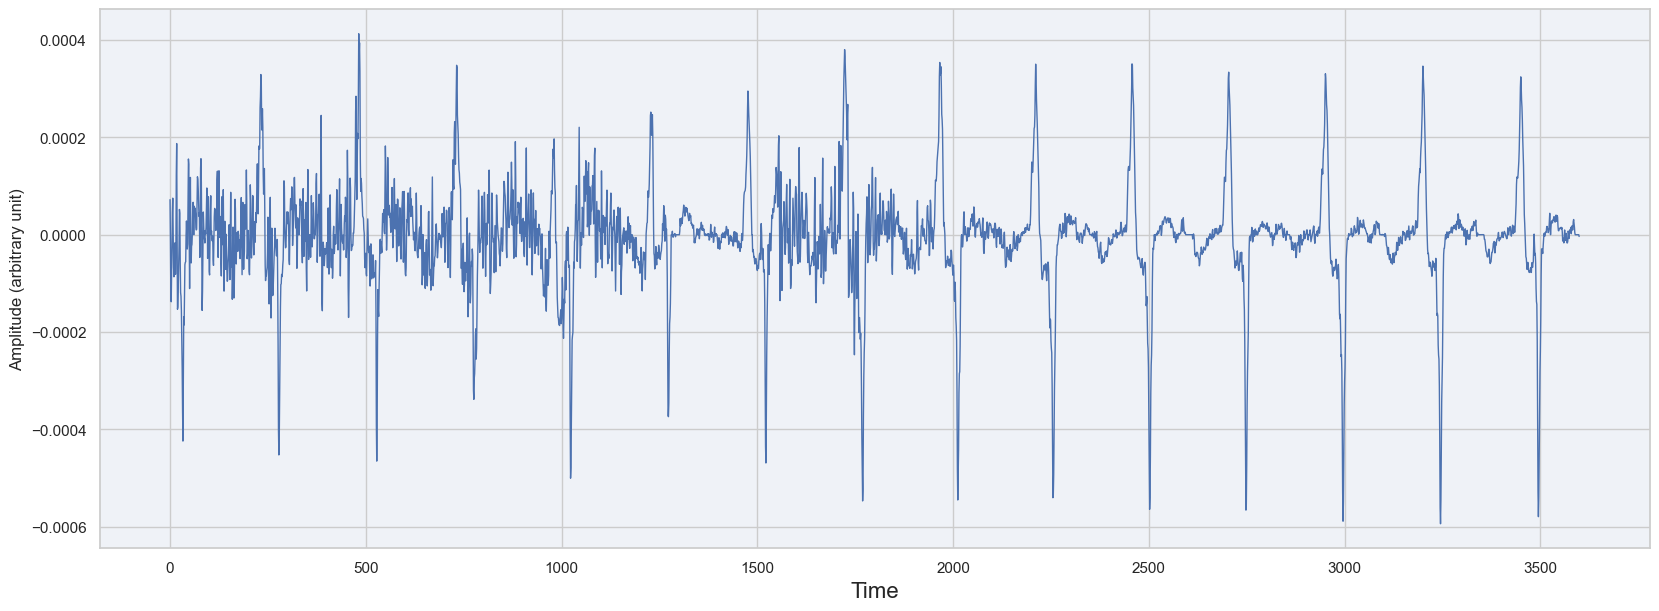

In [122]:
plt.figure(figsize=(20, 7))
start = 0
stop = 3600
duration = (stop-start) / settings['fs']
plt.plot(x[start:stop].index,x[start:stop].MLII,linewidth=1)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

In [151]:
def detect_peaks(ecg_signal, threshold=0.5, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    
    return ecg_signal[similarity > threshold].index, similarity


In [167]:
def get_plot_ranges(start=0, end=500, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

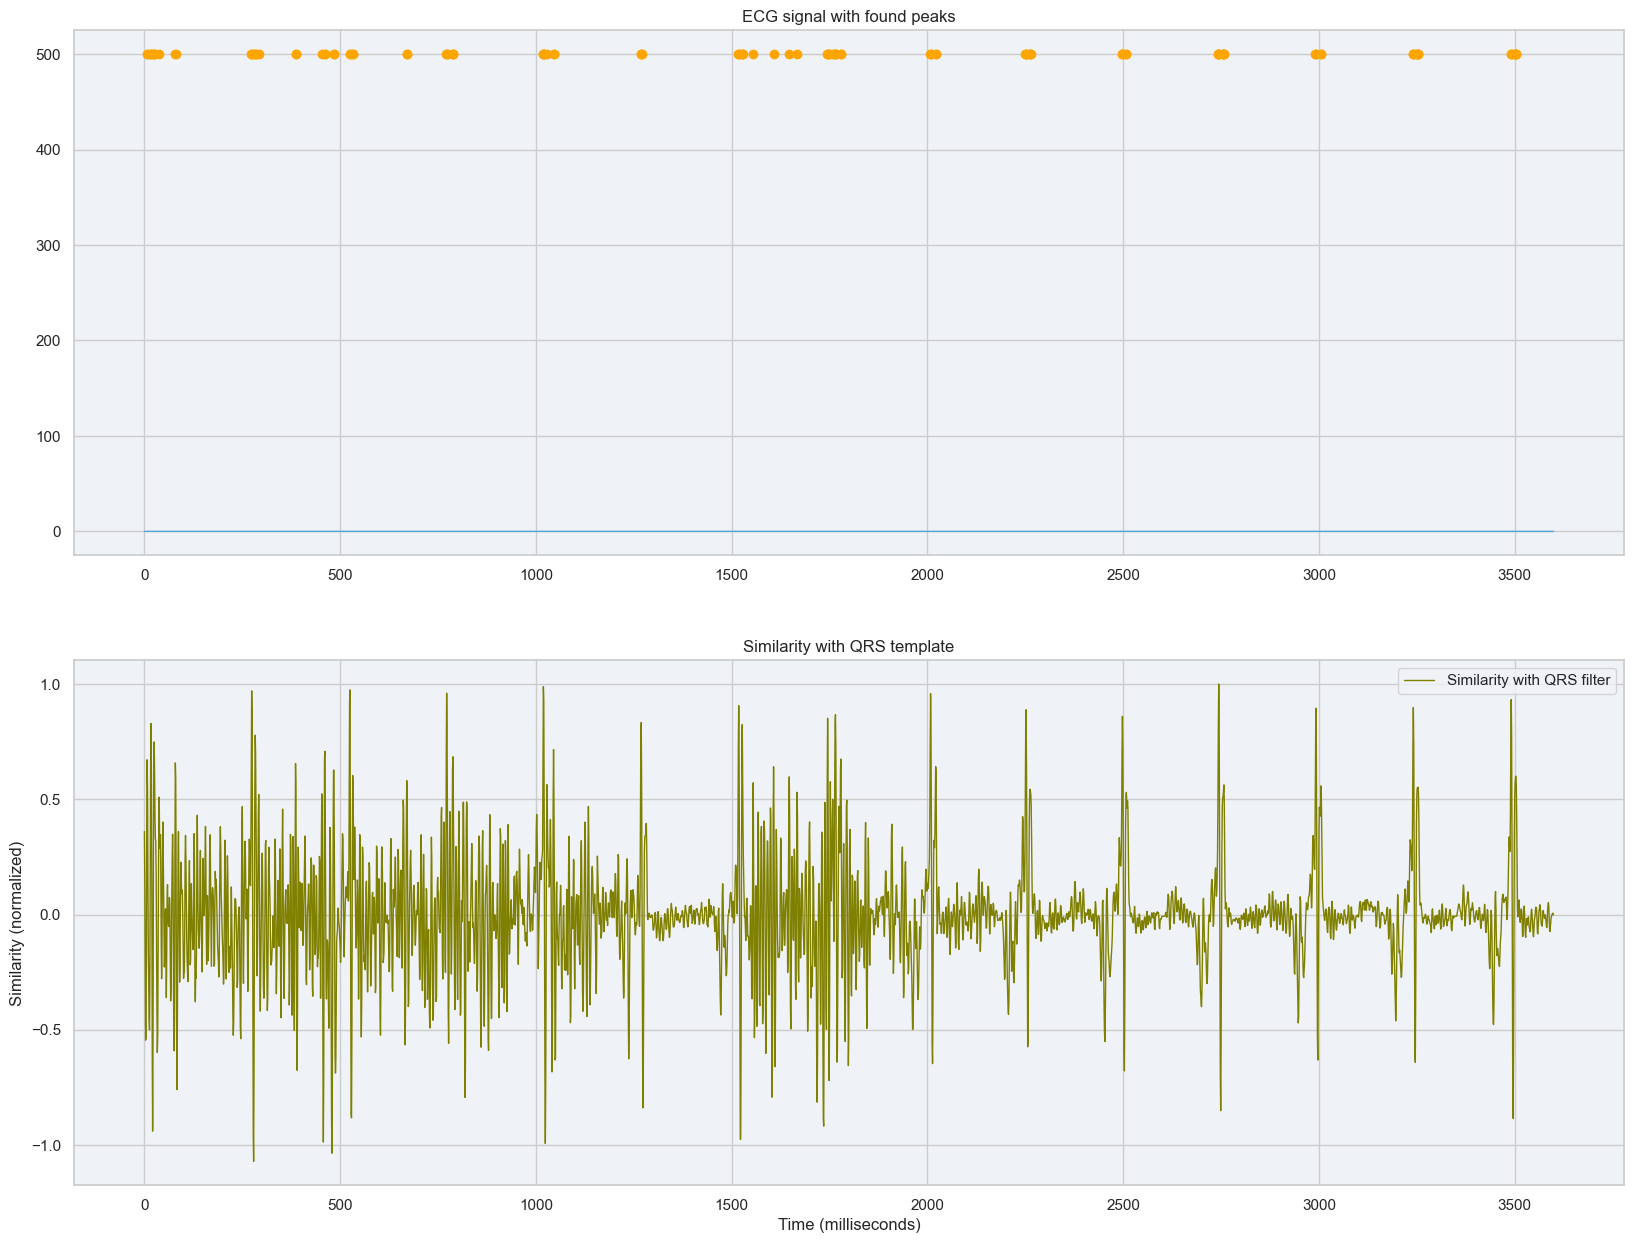

In [168]:
sampfrom = 0
sampto = 3600
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    cond_slice = (x.index >= start) & (x.index < stop) 
    ecg_slice = x.MLII[cond_slice]

    # detect peaks
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.5)
    
    # plot similarity
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(500, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
#     plt.legend(loc="upper right")
#     plt.xlabel("Time (milliseconds)")
#     plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")

In [169]:
peaks, similarity = detect_peaks(ecg_slice, threshold=0.5)
print(list(peaks))

[7, 8, 16, 17, 18, 24, 25, 26, 37, 79, 80, 273, 274, 275, 282, 283, 284, 292, 386, 387, 453, 460, 461, 483, 484, 524, 525, 532, 533, 670, 671, 771, 772, 773, 787, 788, 789, 1018, 1019, 1020, 1021, 1028, 1045, 1046, 1268, 1269, 1270, 1517, 1518, 1519, 1526, 1527, 1528, 1555, 1607, 1647, 1667, 1744, 1745, 1746, 1752, 1758, 1763, 1764, 1765, 1766, 1778, 1779, 2007, 2008, 2009, 2021, 2022, 2250, 2251, 2252, 2253, 2261, 2262, 2263, 2264, 2497, 2498, 2499, 2507, 2508, 2742, 2743, 2744, 2745, 2754, 2755, 2756, 2757, 2758, 2991, 2992, 2993, 3005, 3006, 3240, 3241, 3242, 3250, 3251, 3252, 3253, 3254, 3490, 3491, 3492, 3500, 3501, 3502, 3503, 3504]


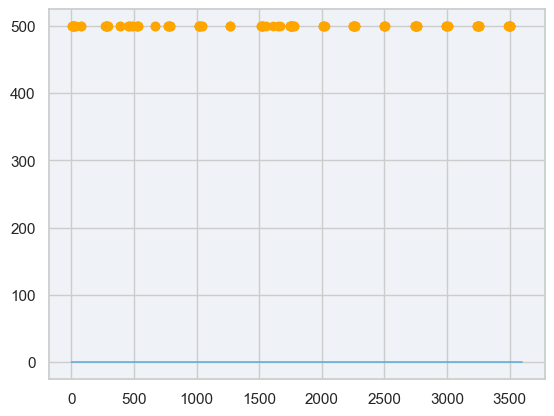

In [170]:
plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
plt.plot(peaks, np.repeat(500, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")

In [171]:
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

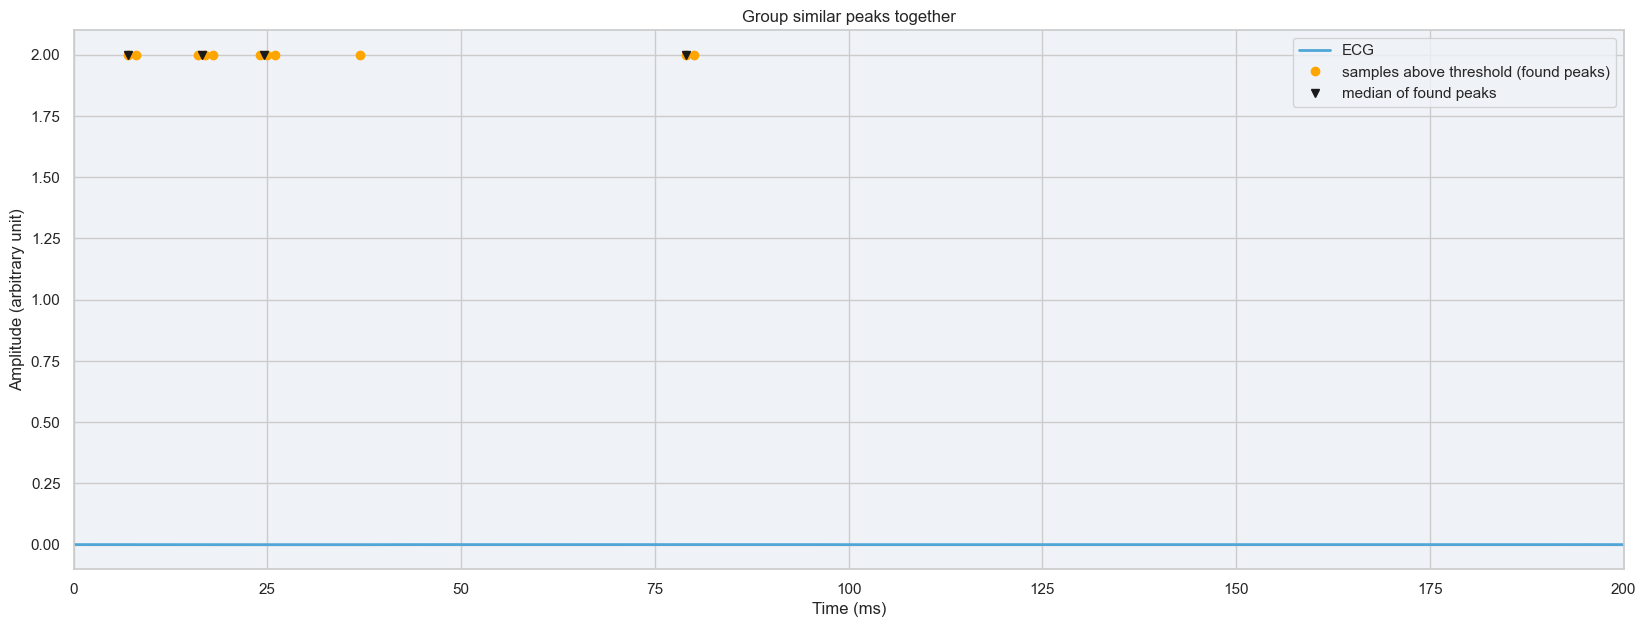

In [172]:
# detect peaks
peaks, similarity = detect_peaks(x.MLII, threshold=0.5)

# group peaks
grouped_peaks = group_peaks(peaks)

# plot peaks
plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(x.index, x.MLII, label="ECG", color="#51A6D8", linewidth=2)

plt.plot(peaks, np.repeat(2, peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(2, grouped_peaks.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (arbitrary unit)")
plt.gca().set_xlim(0, 200)
plt.show()

In [173]:
q=grouped_peaks
q

array([   7. ,   16.5,   24.5,   79. ,  273.5,  282.5,  386. ,  460. ,
        483. ,  524. ,  532. ,  670. ,  771.5,  787.5, 1019. , 1045. ,
       1268.5, 1517.5, 1526.5, 1744.5, 1764. , 1778. , 2007.5, 2021. ,
       2251. , 2262. , 2497.5, 2507. , 2743. , 2755.5, 2991.5, 3005. ,
       3240.5, 3251.5, 3490.5, 3501.5, 3741.5])

In [174]:
len(q)

37

In [178]:
a= []
t= []
for i in range(len(q)):
    
    f = x.loc[x["MLII"].index == q[i]]
    # ag= f["Elapsed time"].tolist()
    #ag[0] = eval(ag[0])
    t.append(f)
t 

[       MLII
 7  0.000075,
 Empty DataFrame
 Columns: [MLII]
 Index: [],
 Empty DataFrame
 Columns: [MLII]
 Index: [],
         MLII
 79  0.000156,
 Empty DataFrame
 Columns: [MLII]
 Index: [],
 Empty DataFrame
 Columns: [MLII]
 Index: [],
          MLII
 386  0.000245,
          MLII
 460  0.000116,
          MLII
 483  0.000368,
          MLII
 524 -0.000081,
          MLII
 532 -0.000157,
          MLII
 670  0.000119,
 Empty DataFrame
 Columns: [MLII]
 Index: [],
 Empty DataFrame
 Columns: [MLII]
 Index: [],
           MLII
 1019 -0.000066,
           MLII
 1045  0.000221,
 Empty DataFrame
 Columns: [MLII]
 Index: [],
 Empty DataFrame
 Columns: [MLII]
 Index: [],
 Empty DataFrame
 Columns: [MLII]
 Index: [],
 Empty DataFrame
 Columns: [MLII]
 Index: [],
           MLII
 1764 -0.000202,
           MLII
 1778  0.000023,
 Empty DataFrame
 Columns: [MLII]
 Index: [],
           MLII
 2021 -0.000004,
           MLII
 2251 -0.000233,
           MLII
 2262 -0.000141,
 Empty DataFrame
 Col

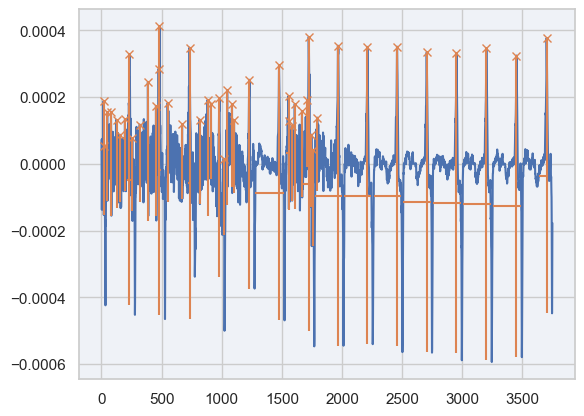

45


In [108]:
x = pd.read_csv("C:\\Users\\xxx\\Downloads\\xxx.csv").iloc[:,-1].values[:]
peaks, properties = find_peaks(x, prominence=0.0002, width=0.05)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.vlines(x=peaks, ymin=x[peaks] - properties["prominences"], ymax = x[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"], xmax=properties["right_ips"], color = "C1")
plt.show()
print(len(peaks))

In [109]:
xx= len(peaks)-len(q)
xx

5

In [110]:
# import os 
# path = "C:\\Users\\xxx\\Desktop\\xxx\\xxx\\"
# files = [x for x in os.listdir(path) if x.endswith('.csv')]

# data = {'FileName':[], 'std_devi':[]}

# for name in files:
#     name = name.split('.')[0]

#     header_list = ['MLII', 'Value', 'VALUE', 'ECG', '0', 'val','V1', 'II', 'noise1', 'noise2','ii']
#     for header in header_list:
#         try:
#             y = pd.read_csv(f'{path}{name}.csv')[header].values
#         except:
#             pass
#         if xx>= 5:
#             # plt.plot(y)
#             plt.savefig(f'C:\\Users\\xxx\\Desktop\\x\\x\\{name}.jpg')
    
#         else:
#             # plt.plot(y)
#             plt.savefig(f'C:\\Users\\x\\Desktop\\x\\x\\{name}.jpg')
#         plt.close()